# Classification of trapped particles
Using forward scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [8]:
def load_data(npoints, folder_path = "D:data ILOF//"):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for j in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('/')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('/')[-1].split('.')[0][-1:])


    return target, np.array(x_data)/np.array(sum_data), np.array(y_data)/np.array(sum_data),np.array(sum_data), np.array(particle_group)


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    cc = 5
    init = cc
    end = -cc
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


        

def pca_data_construct_new_model(data_X, data_Y, data_Sum, ncomp=3 ):
    """
    Train and projects the data in the PCA space, 
    recovers the projection and models
    """
        
    model_X = decomposition.PCA(n_components=ncomp)
    model_X.fit(data_X)
    PCs_X = model_X.transform(data_X)

    model_Y = decomposition.PCA(n_components=ncomp)
    model_Y.fit(data_Y)
    PCs_Y = model_Y.transform(data_Y)

    model_Sum = decomposition.PCA(n_components=ncomp)
    model_Sum.fit(data_Sum)
    PCs_Sum = model_Sum.transform(data_Sum)
    
    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs, [model_X,model_Y,model_Sum]

def pca_data_compute_from_previous_model(data_X, data_Y, data_Sum, models, ncomp=3):
    """
    Projects the data with previously trained pca models
    """
    model_X = models[0]
    model_Y = models[1]
    model_Sum = models[2]
    
    PCs_X = model_X.transform(data_X)

    PCs_Y = model_Y.transform(data_Y)

    PCs_Sum = model_Sum.transform(data_Sum)

    PCs = np.concatenate([PCs_X[:,:],PCs_Y[:,:],PCs_Sum[:,:]],axis=1)
    
    return PCs


In [9]:

def load_data_ILOF(npoints, folder_path = "D:data ILOF//"):

    df = pd.read_csv(folder_path+"info.csv").fillna('0')

    path_files_TD = []
    for i in range(0,len(df)):
            path_files_TD.append(folder_path + df.loc[i]['Filename'])

    target = [] #type of target
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=0,header=None,delimiter='\t')

        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)

        xx = np.array(current_df[0])[0:n_segments*npoints]*0
        yy = np.array(current_df[0])[0:n_segments*npoints]*0
        sums = np.array(current_df[0])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for j in range(0,int(len(xx)/npoints)):

            target.append(str(int(df.loc[i]['Particle size']))+' '+str('\mu m')+ str(df.loc[i]['Polymer']))

            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(str(int(df.loc[i]['Acquisition #'])))


    return target, np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group)




# Load the data

In [17]:

folder = "D:/data OT - TT/Nova pasta (2)/"
folder = "D:/data OT - TT/Vicente2/"
nsegments = 2000
npoints   =  5000
target, x_data, y_data, sum_data, particle_group = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [18]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

In [19]:
#Construct the 6-fold stratified crossvalidation set

def crossval_set(data_X, data_Y, data_Sum, target, particle_group, i):
    """
    Contructs stratified crossvalidation folds taking a particle with number i out and considering it as test
    """
    
    unique_particle_group = np.unique(particle_group)
    
    print("Particle group " + str(i))
        
    #select the test group and append to the lists
    index = np.where(np.array(particle_group) == unique_particle_group[i])[0]
        
    test_sets_data_X = data_X[index]
    test_sets_data_Y = data_Y[index]
    test_sets_data_Sum = data_Sum[index]
    test_sets_labels = target[index]
    test_particle_group = particle_group[index]
        
    #select the train group and append to the lists
    index = np.where(np.array(particle_group) != unique_particle_group[i])[0]
        
    train_sets_data_X = data_X[index]
    train_sets_data_Y = data_Y[index]
    train_sets_data_Sum = data_Sum[index]
    train_sets_labels = target[index]
    train_particle_group = particle_group[index]

    return train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, test_particle_group

In [20]:
#Test model function
def test_a_model(model, train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, 
                 test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, 
                 unique_targets,
                 confusion_matrix = False, ncomp = 2):
    
    """
    Test a given model, returning accuracy results and confusion matrix
    """

    #Train the PC model and obtain the PCs_train projection
    PCs_train,pca_model = pca_data_construct_new_model(train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, ncomp=ncomp)
    
    #use the pca_model previously trained to project the test data
    PCs_test = pca_data_compute_from_previous_model(test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, pca_model, ncomp=ncomp)
    

    model.fit(PCs_train,train_sets_labels)
    score_train = model.score(PCs_train, train_sets_labels)
    score_test = model.score(PCs_test, test_sets_labels)

    #Generate a confusion matrix
    labels_pred = model.predict(PCs_train)
    conf_mat_train = metrics.confusion_matrix(train_sets_labels, labels_pred,normalize="true")
    
    #Generate a confusion matrix
    labels_pred = model.predict(PCs_test)
    conf_mat_pred = metrics.confusion_matrix(test_sets_labels, labels_pred,normalize="true")
        
    if confusion_matrix:
        metrics.ConfusionMatrixDisplay(conf_mat_train,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
        metrics.ConfusionMatrixDisplay(conf_mat_pred,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        

        
        
        
    print("Model Accuracy -> " + str(np.mean(score_test)))
    return score_train, score_test,conf_mat_train,conf_mat_pred

In [21]:
from tqdm import *


model_list_score_train=[]
model_list_score_test=[]
model_list_conf_train=[]
model_list_conf_test=[]

models_to_test=[ensemble.RandomForestClassifier(n_estimators=100,random_state=0), 
                neighbors.KNeighborsClassifier(30)]
                #svm.SVC(kernel="linear", C=0.25),
               #linear_model.LogisticRegression(),
                #neural_network.MLPClassifier(activation = 'tanh')]

pbar = tqdm(total=len(models_to_test)*len(np.unique(particle_group)))

for model in models_to_test:

    list_score_train =[]
    list_score_test = []
    list_conf_train = []
    list_conf_test = []
    print(model)
    
    
    for index in range(0,len(np.unique(particle_group))):
        pbar.update(1)
        
        train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, test_particle_group = crossval_set(data_X, data_Y, data_Sum, labels, particle_group,index)

        print(np.unique(train_particle_group), end= '\t')
        print(np.unique(test_particle_group))

        score_train, score_test, conf_train, conf_test = test_a_model(model, train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, 
                     test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, 
                     unique_targets,
                     confusion_matrix = False, ncomp = 2)

        list_score_train.append(score_train)
        list_score_test.append(score_test)
        list_conf_train.append(conf_train)
        list_conf_test.append(conf_test)
    

    model_list_score_train.append(list_score_train)
    model_list_score_test.append(list_score_test)
    model_list_conf_train.append(np.array(list_conf_train).mean(axis=0))
    model_list_conf_test.append(np.array(list_conf_test).mean(axis=0))
    
    


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

RandomForestClassifier(random_state=0)
Particle group 0
['7' '8' '9']	['6']



 25%|█████████████████████                                                               | 2/8 [00:01<00:03,  1.85it/s]

Model Accuracy -> 0.5794871794871795
Particle group 1
['6' '8' '9']	['7']



 38%|███████████████████████████████▌                                                    | 3/8 [00:02<00:04,  1.25it/s]

Model Accuracy -> 0.5216284987277354
Particle group 2
['6' '7' '9']	['8']



 50%|██████████████████████████████████████████                                          | 4/8 [00:03<00:03,  1.07it/s]

Model Accuracy -> 0.811704834605598
Particle group 3
['6' '7' '8']	['9']



 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:04<00:02,  1.02it/s]

Model Accuracy -> 0.5076530612244898
KNeighborsClassifier(n_neighbors=30)
Particle group 0
['7' '8' '9']	['6']



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:05<00:01,  1.05it/s]

Model Accuracy -> 0.5487179487179488
Particle group 1
['6' '8' '9']	['7']



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:06<00:00,  1.02it/s]

Model Accuracy -> 0.5216284987277354
Particle group 2
['6' '7' '9']	['8']



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]

Model Accuracy -> 0.8371501272264631
Particle group 3
['6' '7' '8']	['9']
Model Accuracy -> 0.6479591836734694


In [22]:
import itertools
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=cm.Blues):

  figure(figsize=(9,6))

  imshow(cm,interpolation='nearest',cmap=cmap)
  colorbar()

  tick_marks=np.arange(len(classes))
  xticks(tick_marks,classes,rotation=45,fontsize=12)
  yticks(tick_marks,classes,rotation=0,fontsize=12)

  if normalize:
     cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
     cm=np.around(cm,decimals=2)
     cm[np.isnan(cm)]=0.0
     print('Normalized confusion matrix')

  else:
     print('Confusion matrix, without normalization')


  thresh=cm.max()/2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

    text(j, i, cm[i, j],
             horizontalalignment="center",fontsize=12,
             color="white" if cm[i, j] > thresh else "black")

    tight_layout()

    ylabel('True label',fontsize=20)
    xlabel('Predicted label',fontsize=20)

RandomForestClassifier(random_state=0)
Accuracy Train -> 1.0	1.0	1.0
Accuracy Test -> 0.6051183935112507	0.811704834605598	0.5076530612244898


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead


<IPython.core.display.Javascript object>


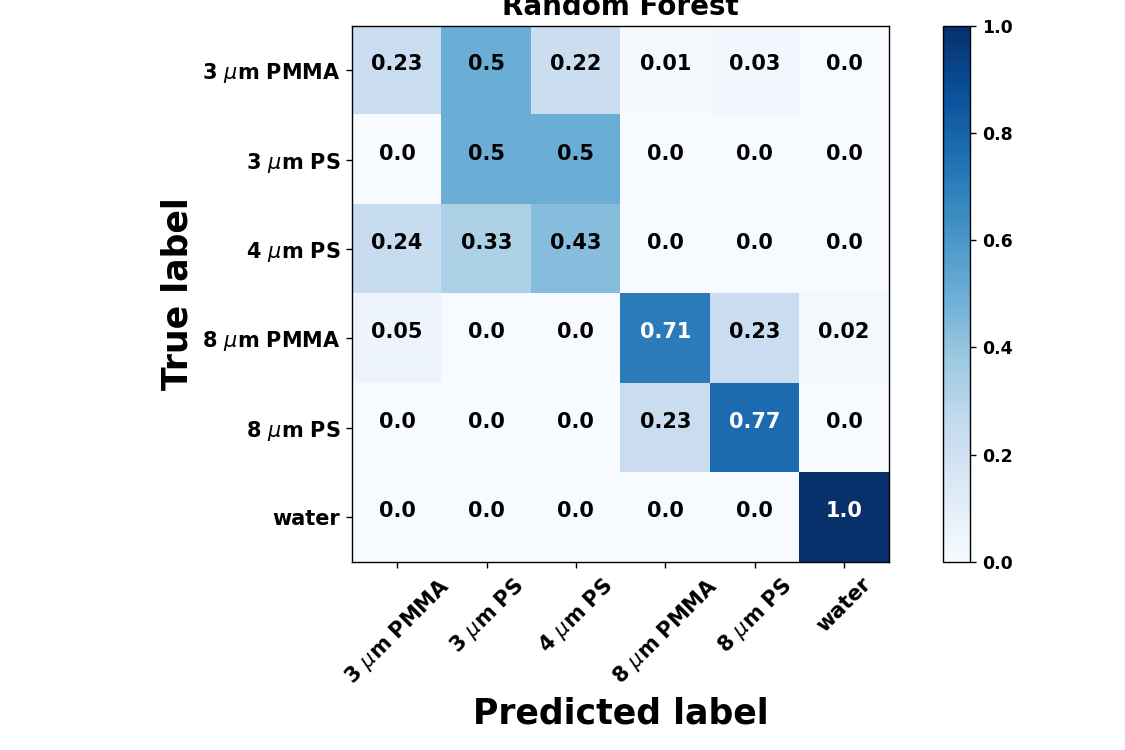

Confusion matrix, without normalization
KNeighborsClassifier(n_neighbors=30)
Accuracy Train -> 0.9861754567809856	0.9974533106960951	0.9770212765957447
Accuracy Test -> 0.6388639395864042	0.8371501272264631	0.5216284987277354


<IPython.core.display.Javascript object>


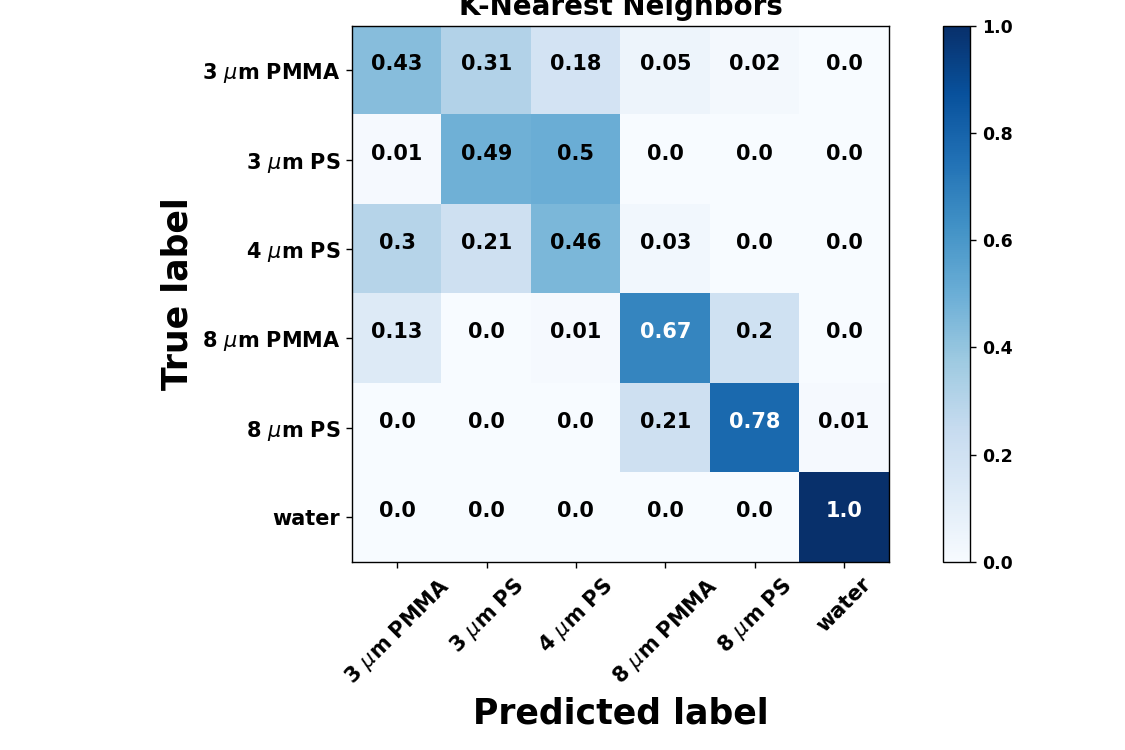

Confusion matrix, without normalization


In [23]:
%matplotlib notebook

unique_targets1=[]
for i in range(0,len(unique_targets)):
    unique_targets1.append(r''+unique_targets[i].replace('um',' $\mu$m ').replace('POLY','PS'))

models_labels=['Random Forest', 
                       'K-Nearest Neighbors',
                       'Support Vector Machine Classifier',
                       'Logistic Regression',
                       'Multi-layer Perceptron']
    
    
    
for i in range(0,len(models_to_test)):
    print(models_to_test[i])
    print("Accuracy Train -> "+ str(mean(model_list_score_train[i])), end = '\t')
    print(str(max(model_list_score_train[i])), end = '\t')
    print(str(min(model_list_score_train[i])), end = '\n')
    
    print("Accuracy Test -> "+ str(mean(model_list_score_test[i])), end = '\t')
    print(str(max(model_list_score_test[i])), end = '\t')
    print(str(min(model_list_score_test[i])), end = '\n')
    
    
    conf_mat_pred = model_list_conf_test[i]
    #metrics.ConfusionMatrixDisplay(np.round(conf_mat_pred,2),display_labels=unique_targets1).plot(cmap=cm.Blues)
    
    plot_confusion_matrix(np.round(conf_mat_pred,2),unique_targets1)

    ax=gca()
    ax.set_title(models_labels[i],fontsize=16)
    savefig('images//QPD - micro//'+models_labels[i], bbox_inches='tight',dpi=300)
        